In [1]:
%matplotlib inline

In [2]:
import sys 
import os.path
sys.path += [os.path.abspath("../../")]

In [3]:
from lib import filedb
import pandas as pd
import numpy as np
from lib import strainmap
#from figures.figure_63x_sigb_histo import subfig_indivfile_histo
from lib.analysis.sigb_histograms import make_indivfile_histogram
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import scipy.stats

In [4]:
basedir = "/media/nmurphy/BF_Data_Orange/datasets/new_strain_snaps1/"
cell_df = pd.read_hdf(os.path.join(basedir, "single_cell_data.h5"), "cells")
file_df = filedb.get_filedb(os.path.join(basedir, "file_list.tsv"))

In [5]:
cell_df.columns

Index(['image_row', 'image_col', 'distance', 'slice_row', 'slice_col',
       'segment_label', 'area', 'length', 'perimeter', 'eccentricity',
       'red_raw_std', 'red_raw_mean', 'red_raw_meannorm', 'red_raw_maxnorm',
       'green_raw_std', 'green_raw_mean', 'green_raw_meannorm',
       'green_raw_maxnorm', 'global_file_id'],
      dtype='object')

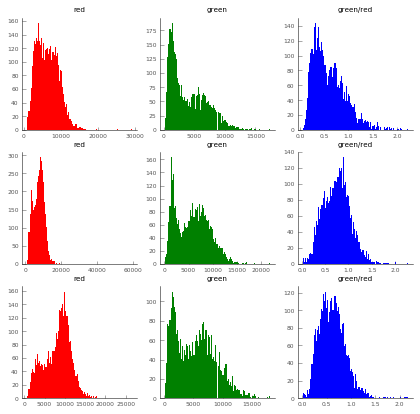

In [107]:
files = cell_df.global_file_id.unique()
fig, ax = plt.subplots(len(files), 3)
fig.set_size_inches(7,7)
for i, fid in enumerate(files):
    grn = cell_df.loc[cell_df["global_file_id"]==fid, "green_raw_mean"]
    red = cell_df.loc[cell_df["global_file_id"]==fid, "red_raw_mean"]
    ax[i, 0].hist(red, bins=100, color="red")
    ax[i, 1].hist(grn, bins=100, color="green")
    ax[i, 2].hist(grn/red, bins=100, color="blue")
    ax[i, 0].set_title("red")
    ax[i, 1].set_title("green")
    ax[i, 2].set_title("green/red")


fig.savefig("/tmp/raw_image_histograms.png")

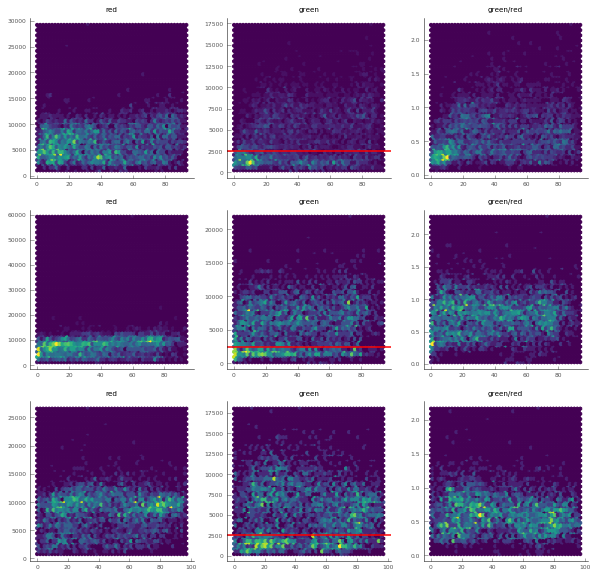

In [110]:
files = cell_df.global_file_id.unique()
fig, ax = plt.subplots(len(files), 3)
fig.set_size_inches(10,10)
for i, fid in enumerate(files):
    grn = cell_df.loc[cell_df["global_file_id"]==fid, "green_raw_mean"]
    red = cell_df.loc[cell_df["global_file_id"]==fid, "red_raw_mean"]
    distance = cell_df.loc[cell_df["global_file_id"]==fid, "distance"]
    ax[i, 0].hexbin(distance, red,   gridsize=50)
    ax[i, 1].hexbin(distance, grn,  gridsize=50)
    ax[i, 2].hexbin(distance, grn/red,   gridsize=50)
    ax[i, 1].axhline(2500, color="red")
    ax[i, 0].set_title("red")
    ax[i, 1].set_title("green")
    ax[i, 2].set_title("green/red")
fig.savefig("/tmp/bimod.png", layout="tight")

# Where are the low brightness (green) cells?

Are they sgementation errors? 

In [31]:
file_df

,path,name,dirname,time,location,strain
file_id,,,,,,
0,NaN,JLB088_48hrs_63x_1,Set_2/48hrs/63x,48.0,livedish,jlb088
1,NaN,JLB088_48hrs_63x_2,Set_2/48hrs/63x,48.0,livedish,jlb088
2,NaN,JLB088_48hrs_63x_3,Set_2/48hrs/63x,48.0,livedish,jlb088


In [33]:
import skimage.morphology

In [112]:
redb = 1.0
greenb = 1.0
based = "/media/nmurphy/BF_Data_Orange/proc_data/new_strain_snaps1/images"

for i, fid in enumerate(files):
    red = skimage.io.imread("{0}/{1}/{2}/{2}_cr.tiff".format(based, file_df.loc[fid, "dirname"], file_df.loc[fid, "name"]))
    #     grn = skimage.io.imread("{0}/{1}/{2}/{2}_cg.tiff".format(based, file_df.loc[fid, "dirname"], file_df.loc[fid, "name"]))
    #im = np.dstack([red*redb, grn*grnb, np.zeros_list(grn)])
    blank = np.zeros_like(red)
    probcels = cell_df[(cell_df["global_file_id"] == fid) & (cell_df["green_raw_mean"]<2500)]
    blank[probcels["image_row"],probcels["image_col"]] = (2**16)-1
    blank = skimage.morphology.dilation(blank, selem=skimage.morphology.disk(3))
    skimage.io.imsave("{0}/{1}/{2}/{2}_debug.tiff".format(based, file_df.loc[fid, "dirname"], file_df.loc[fid, "name"]), blank)
    

/home/nmurphy/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /media/nmurphy/BF_Data_Orange/proc_data/new_strain_snaps1/images/Set_2/48hrs/63x/JLB088_48hrs_63x_2/JLB088_48hrs_63x_2_debug.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/nmurphy/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /media/nmurphy/BF_Data_Orange/proc_data/new_strain_snaps1/images/Set_2/48hrs/63x/JLB088_48hrs_63x_3/JLB088_48hrs_63x_3_debug.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


The bi-modol population has 2 origins,
- many cells seem to be in another plane but are segmented anyway. it seems that about 7000 red units is a good threshold. 
- sporeulating cells are segmented as 2 cells and the spore bit is quite dim


In [68]:
cell_df_filter = cell_df.loc[cell_df["red_raw_mean"] > 7000, :].copy()

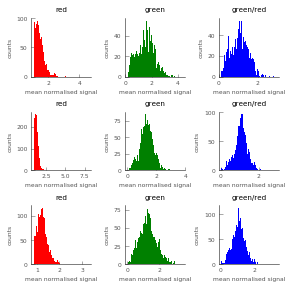

In [117]:
files = cell_df.global_file_id.unique()
fig, ax = plt.subplots(len(files), 3)
fig.set_size_inches(4,4)

for i, fid in enumerate(files):
    grn = cell_df_filter.loc[cell_df_filter["global_file_id"]==fid, "green_raw_meannorm"]
    red = cell_df_filter.loc[cell_df_filter["global_file_id"]==fid, "red_raw_meannorm"]
    ax[i, 0].hist(red, bins=100, color="red")
    ax[i, 1].hist(grn, bins=100, color="green")
    ax[i, 2].hist(grn/red, bins=100, color="blue")
    ax[i, 0].set_title("red")
    ax[i, 1].set_title("green")
    ax[i, 2].set_title("green/red")
    
for a in ax.flatten():
    a.set_ylabel("counts")
    a.set_xlabel("mean normalised signal")
    
fig.tight_layout()
fig.savefig("/tmp/new_histo.png")

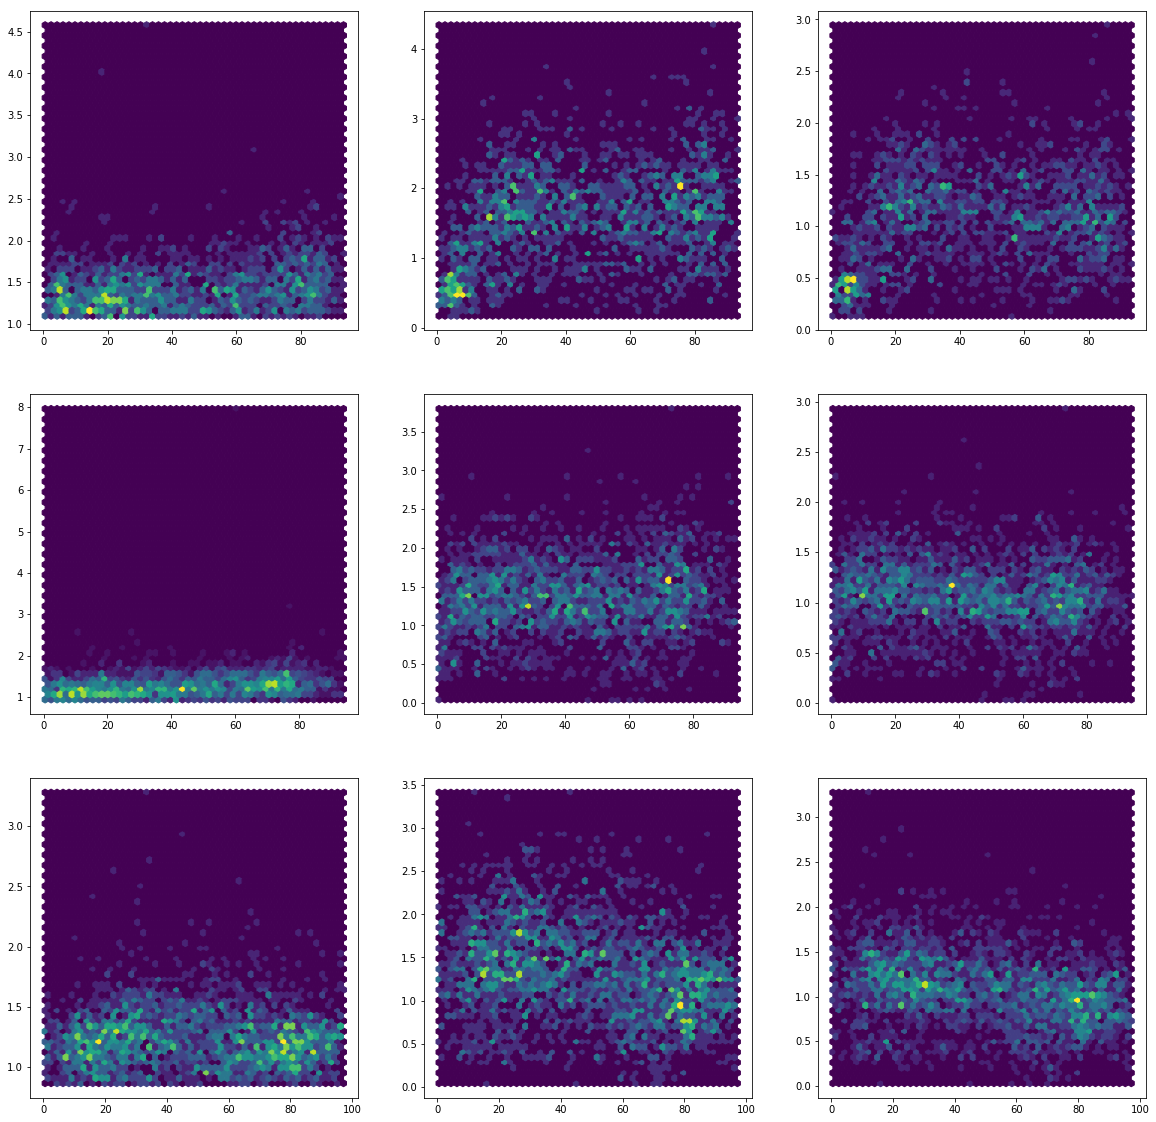

In [78]:
files = cell_df.global_file_id.unique()
fig, ax = plt.subplots(len(files), 3)
fig.set_size_inches(20,20)
for i, fid in enumerate(files):
    grn = cell_df_filter.loc[cell_df_filter["global_file_id"]==fid, "green_raw_meannorm"]
    red = cell_df_filter.loc[cell_df_filter["global_file_id"]==fid, "red_raw_meannorm"]
    distance = cell_df_filter.loc[cell_df_filter["global_file_id"]==fid, "distance"]
    ax[i, 0].hexbin(distance, red,   gridsize=50)
    ax[i, 1].hexbin(distance, grn,  gridsize=50)
    ax[i, 2].hexbin(distance, grn/red,   gridsize=50)
    #ax[i, 1].axhline(2500)

In [111]:
redb = 1.0
greenb = 1.0
based = "/media/nmurphy/BF_Data_Orange/proc_data/new_strain_snaps1/images"

for i, fid in enumerate(files):
    red = skimage.io.imread("{0}/{1}/{2}/{2}_cr.tiff".format(based, file_df.loc[fid, "dirname"], file_df.loc[fid, "name"]))
    #     grn = skimage.io.imread("{0}/{1}/{2}/{2}_cg.tiff".format(based, file_df.loc[fid, "dirname"], file_df.loc[fid, "name"]))
    #im = np.dstack([red*redb, grn*grnb, np.zeros_list(grn)])
    blank = np.zeros_like(red)
    probcels = cell_df_filter[(cell_df_filter["global_file_id"] == fid) & (cell_df_filter["green_raw_mean"]<2500)]
    blank[probcels["image_row"],probcels["image_col"]] = (2**16)-1
    blank = skimage.morphology.dilation(blank, selem=skimage.morphology.disk(3))
    skimage.io.imsave("{0}/{1}/{2}/{2}_debug2.tiff".format(based, file_df.loc[fid, "dirname"], file_df.loc[fid, "name"]), blank)
    

/home/nmurphy/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /media/nmurphy/BF_Data_Orange/proc_data/new_strain_snaps1/images/Set_2/48hrs/63x/JLB088_48hrs_63x_1/JLB088_48hrs_63x_1_debug2.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/nmurphy/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /media/nmurphy/BF_Data_Orange/proc_data/new_strain_snaps1/images/Set_2/48hrs/63x/JLB088_48hrs_63x_2/JLB088_48hrs_63x_2_debug2.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)
/home/nmurphy/anaconda3/envs/py36/lib/python3.6/site-packages/skimage/io/_io.py:140: UserWarning: /media/nmurphy/BF_Data_Orange/proc_data/new_strain_snaps1/images/Set_2/48hrs/63x/JLB088_48hrs_63x_3/JLB088_48hrs_63x_3_debug2.tiff is a low contrast image
  warn('%s is a low contrast image' % fname)


In [74]:
redb = 1.0
greenb = 1.0
based = "/media/nmurphy/BF_Data_Orange/proc_data/new_strain_snaps1/images"

for i, fid in enumerate(files):
    red = skimage.io.imread("{0}/{1}/{2}/{2}_cr.tiff".format(based, file_df.loc[fid, "dirname"], file_df.loc[fid, "name"]))
    #     grn = skimage.io.imread("{0}/{1}/{2}/{2}_cg.tiff".format(based, file_df.loc[fid, "dirname"], file_df.loc[fid, "name"]))
    #im = np.dstack([red*redb, grn*grnb, np.zeros_list(grn)])
    blank = np.zeros_like(red)
    probcels = cell_df_filter[(cell_df_filter["global_file_id"] == fid)]
    blank[probcels["image_row"],probcels["image_col"]] = (2**16)-1
    blank = skimage.morphology.dilation(blank, selem=skimage.morphology.disk(3))
    skimage.io.imsave("{0}/{1}/{2}/{2}_debug3.tiff".format(based, file_df.loc[fid, "dirname"], file_df.loc[fid, "name"]), blank)
    

In [ ]:
What does the histogram  look like compared to the paper. 

In [79]:
sys.path += [os.path.realpath("../../figures/figure_63x_sigb_histo/")]
import subfig_indivfile_histo


In [96]:
max_val = 6.5 #2.5 
gmax_val = 6.5 #0.75
nbins = 150
rbins = (0, max_val, nbins)
gbins = (0, gmax_val, nbins)
slice_srt, slice_end = 5, 7 #10, 15
percentile=0

mean: 0.93
std: 0.38
CV: 0.41
Moment skew: 0.08
Kurtosis -0.71
Number of files: 3
Cells: 275
------------------------
mean: 0.77
std: 0.52
CV: 0.68
Moment skew: 0.76
Kurtosis -0.31
Number of files: 3
Cells: 275
------------------------


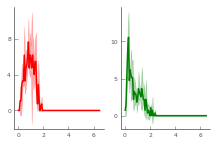

In [120]:
fids = file_df[(file_df["time"] == 48) &
                (file_df["strain"] == "jlb088")].index
strain_df = cell_df[cell_df["global_file_id"].isin(fids)]
#print(strain_df)
dset = 48, "center", "jlb088"
tbins = gbins
gchan="green_raw_meannorm"
rchan="red_raw_meannorm"

    
list_of_histos = [ 
        ("wt_sigar_sigby", rchan,   "ΔrsbRU P$_{sigA}$-RFP",      "red"),
        ("wt_sigar_sigby", gchan, "ΔrsbRU P$_{sigB}$-YFP",        "green")]

fig, axhisto = plt.subplots(1,len(list_of_histos))
fig.set_size_inches(3,2)
for i, (strain, chan, label, color) in enumerate(list_of_histos):

    if "red" in chan:
        tbins = rbins
    plot_args = {"color":color, "max_min":"std", "mode_mean": False}

    args = (axhisto[i], strain_df, chan, tbins, (slice_srt, slice_end), dset, percentile, False, ".", plot_args)
    axhisto[i], _, meandmed = subfig_indivfile_histo.get_figure(*args)
fig.tight_layout()
fig.savefig("/tmp/paper_hist.png")

# Load up the rest of the plots

In [6]:
strain_c = {s: i for i,s in enumerate(np.unique(file_df["strain"]))}
len(strain_c)

12

In [ ]:
files = cell_df.global_file_id.unique()
fig, ax = plt.subplots(len(files), 3)
fig.set_size_inches(6,20)
fig.set_dpi(80)
for i, fid in enumerate(files):
    grn = cell_df.loc[cell_df["global_file_id"]==fid, "green_raw_mean"]
    red = cell_df.loc[cell_df["global_file_id"]==fid, "red_raw_mean"]
    ax[i, 0].hist(red, bins=100, color="red")
    ax[i, 1].hist(grn, bins=100, color="green")
    ax[i, 2].hist(grn/red, bins=100, color="blue")

    ax[i, 0].set_ylabel(file_df.loc[fid, "strain"])
    strain = file_df.loc[fid, "strain"]
    ax[i, 0].set_xlim(0,30000)
    ax[i, 1].set_xlim(0,50000)
    ax[i, 2].set_xlim(0,5)
    color = plt.cm.tab10(strain_c[strain]/len(strain_c))
    for a in ax[i, :]:
        a.set_facecolor(color)
        a.set_ylim(0,300)
ax[0, 0].set_title("red")
ax[0, 1].set_title("green")
ax[0, 2].set_title("green/red")
    
fig.tight_layout()

/home/nmurphy/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/tight_layout.py:211: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


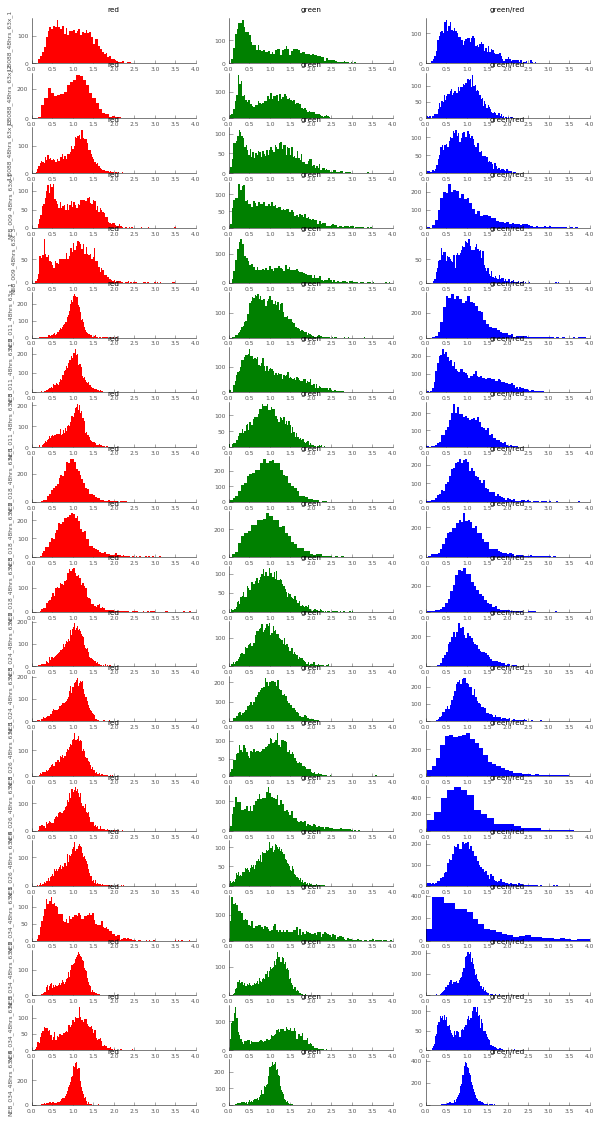

In [132]:
files = cell_df.global_file_id.unique()
fig, ax = plt.subplots(len(files), 3)
fig.set_size_inches(10,20)
for i, fid in enumerate(files):
    grn = cell_df.loc[cell_df["global_file_id"]==fid, "green_raw_meannorm"]
    red = cell_df.loc[cell_df["global_file_id"]==fid, "red_raw_meannorm"]
    ax[i, 0].hist(red, bins=100, color="red")
    ax[i, 1].hist(grn, bins=100, color="green")
    ax[i, 2].hist(grn/red, bins=100, color="blue")
    ax[i, 0].set_title("red")
    ax[i, 1].set_title("green")
    ax[i, 2].set_title("green/red")
    ax[i, 0].set_ylabel(file_df.loc[fid, "name"])
    
for a in ax.flatten():
    a.set_xlim(0, 4)

In [10]:
import scipy.stats

In [11]:
gamma_fit = scipy.stats.gamma.fit(cell_df["red_raw_mean"])

In [24]:
cell_df["red_raw_mean"].median()

9324.833333333334

In [60]:
gamma_fit = (21, -8400, 900)

In [61]:
18 * 1100

19800

In [62]:
x = np.arange(0, 30000)

In [63]:
y = scipy.stats.gamma.pdf(x, *gamma_fit)

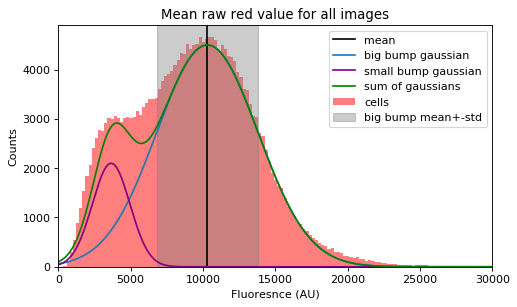

In [161]:
fig, ax = plt.subplots(1, 1)

ax = np.atleast_2d(ax)

fig.set_dpi(80)
fig.set_size_inches(7,4)
i = 0

ax[i, 0].hist(red, bins=300, color="red", label="cells", alpha=0.5)#, density=True)

x = np.arange(0, 30000)
mean = 10300
std = 3500
y = scipy.stats.norm.pdf(x, mean, std)
ax[i, 0].axvline(mean, color="black", label="mean")
ax[i, 0].axvspan(mean-std, mean+std,  color='grey', alpha=0.4, label="big bump mean+-std")

#maxp = 0.00009
maxp = 4500 # max point for scaling

y *= maxp/y.max()
ax[i, 0].plot(x, y, label="big bump gaussian")


x = np.arange(0, 30000)
ys = scipy.stats.norm.pdf(x, 3650, 1300)
#maxp = 0.000045
maxp = 2100

ys *= maxp/ys.max()
ax[i, 0].plot(x, ys, label="small bump gaussian", color="purple")

ax[i, 0].plot(x, y+ys,  label="sum of gaussians", color="green")

ax[i, 0].set_title("Mean raw red value for all images")
ax[i,0].set_xlabel("Fluoresnce (AU)")
ax[i,0].set_ylabel("Counts")

ax[i, 0].set_xlim(0, 30000)
    
ax[i, 0].legend()
fig.savefig("/tmp/removing_strange_cells1.png")

In [7]:
def is_a_good_cell(v, mean = 10300, std = 3500):
    if (v < mean + std) & (v > mean - std):
        return True
    else:
        return False

In [8]:
cell_df_filter = cell_df.loc[cell_df["red_raw_mean"].apply(is_a_good_cell), :]

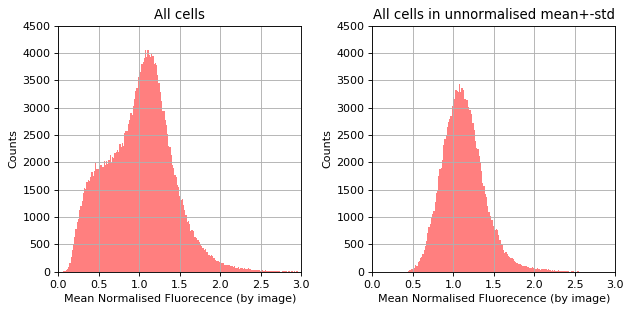

In [9]:
fig, ax = plt.subplots(1, 2)
fig.set_dpi(80)
fig.set_size_inches(8,4)
cell_df["red_raw_meannorm"].hist(bins=np.linspace(0, 3.0, 200), ax=ax[0], color="red", alpha=0.5)
cell_df_filter["red_raw_meannorm"].hist(bins=np.linspace(0, 3.0, 200), ax=ax[1], color="red", alpha=0.5)
for a in ax:
    a.set_xlim(0, 3.0)
    a.set_ylim(0, 4500)
    a.set_xlabel("Mean Normalised Fluorecence (by image)")
    a.set_ylabel("Counts")
    
ax[0].set_title("All cells")
ax[1].set_title("All cells in unnormalised mean+-std")
fig.tight_layout()
fig.savefig("/tmp/removing_strange_cells2.png")

### RFP vs YFP 

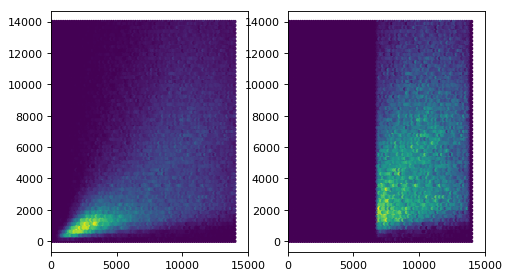

In [10]:
fig, ax = plt.subplots(1, 2)

ax = np.atleast_2d(ax)

fig.set_dpi(80)
fig.set_size_inches(7,4)
i = 0

ax[i, 0].hexbin(cell_df["red_raw_mean"], cell_df["green_raw_mean"],  label="cells", extent=(0, 14000, 0, 14000))#, density=True)

ax[i, 1].hexbin(cell_df_filter["red_raw_mean"], cell_df_filter["green_raw_mean"], extent=(0, 14000, 0, 14000), label="cells")#, density=True)

# x = np.arange(0, 30000)
# mean = 10300
# std = 3500
# y = scipy.stats.norm.pdf(x, mean, std)
# ax[i, 0].axvline(mean, color="black", label="mean")
# ax[i, 0].axvspan(mean-std, mean+std,  color='grey', alpha=0.4, label="big bump mean+-std")

# #maxp = 0.00009
# maxp = 4500 # max point for scaling

# y *= maxp/y.max()
# ax[i, 0].plot(x, y, label="big bump gaussian")


# x = np.arange(0, 30000)
# ys = scipy.stats.norm.pdf(x, 3650, 1300)
# #maxp = 0.000045
# maxp = 2100

# ys *= maxp/ys.max()
# ax[i, 0].plot(x, ys, label="small bump gaussian", color="purple")

# ax[i, 0].plot(x, y+ys,  label="sum of gaussians", color="green")

# ax[i, 0].set_title("Mean raw red value for all images")
# ax[i,0].set_xlabel("Fluoresnce (AU)")
# ax[i,0].set_ylabel("Counts")

for a in ax.flatten():
    a.set_xlim(0, 15000)
    
# ax[i, 0].legend()
# fig.savefig("/tmp/removing_strange_cells1.png")